In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle
from copy import deepcopy

comment = "Generate simple example with fisher func"
nb_name = "nb_seqsim_simple_ex_fisher_TI_based"

# Power spectrum baseline

<IPython.core.display.Javascript object>


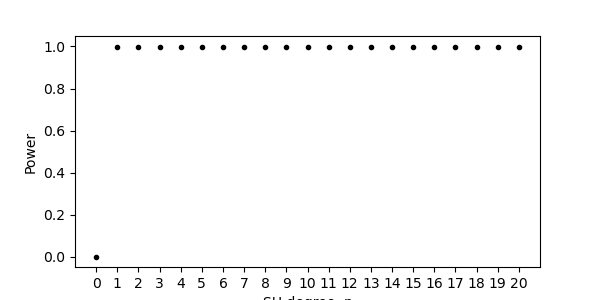

In [2]:
degrees = np.arange(1,22, dtype=float)

power = np.flip(degrees**(-1))
power = np.hstack((0,np.ones(20)))


plt.figure(figsize=(6,3))
plt.plot(power,"k.")
plt.xlabel("SH degree, n")
plt.ylabel("Power")
plt.xticks(np.arange(0,21))
plt.show()

# Surface truth

<IPython.core.display.Javascript object>


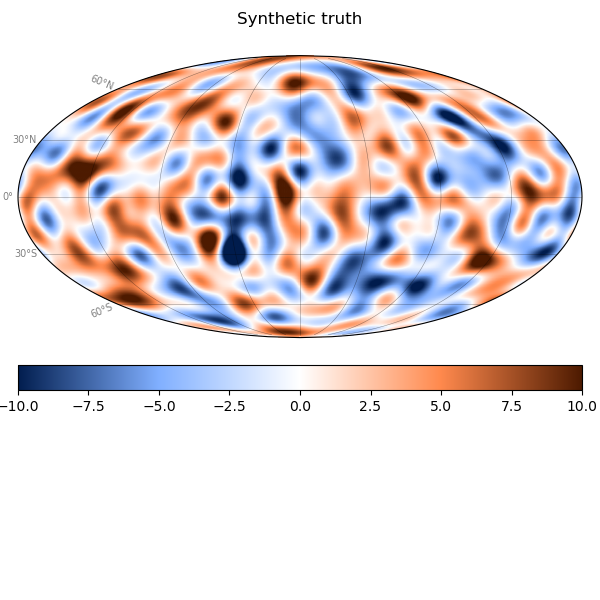

In [3]:
shn = 20
glq_r = 1

# Generate surface truth object
surface_t = SDSS(comment, N_SH = shn, sim_type = "core")
surface_t.grid_glq(nmax = shn, r_at = glq_r)
grid_in = np.array([surface_t.grid_phi, 90-surface_t.grid_theta]).T
surface_t.make_grid(glq_r, grid_in, calc_sph_d = True)

# Get random surface based on int seed
rand_int = 67803
clm = pyshtools.SHCoeffs.from_random(power, seed=rand_int)
grid = clm.expand()
coeffs = clm.to_array(lmax=shn)

# Set data from random SH coeffs
surface_t.data = pyshtools.expand.MakeGridGLQ(coeffs, surface_t.grid_zero, [surface_t.grid_nmax, 1, 1, shn, False]).reshape(-1,)
surface_t.target_var = np.var(surface_t.data)
surface_t.target_mean = 0.0
surface_t.g_prior, surface_t.g_prior_cilm = mt_util.sh_expand_glq(surface_t.data, 
                             surface_t.grid_nmax, surface_t.grid_w_shtools, surface_t.grid_zero, 
                             shn, geomag_scale = False)

# Plot surface truth
import importlib
importlib.reload(mt_util)
surface_t.grid_glq(nmax = 400, r_at = 1.0)
surface_truth = mt_util.sh_makegrid_glq(surface_t.g_prior, surface_t.grid_nmax, surface_t.grid_zero, 20)
mt_util.plot_global(lat = 90-surface_t.grid_theta, lon = surface_t.grid_phi, data=surface_truth, limits_data = [-10,10],
                title='Synthetic truth', savefig = False, save_dpi = 100, save_string ="simple_ex_fisher_truth", save_path = "images/",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, 
                rasterize = True, point_size=0.1, coast_width = 0.0)
surface_t.grid_glq(nmax = shn, r_at = glq_r)

# Surface prior

<IPython.core.display.Javascript object>


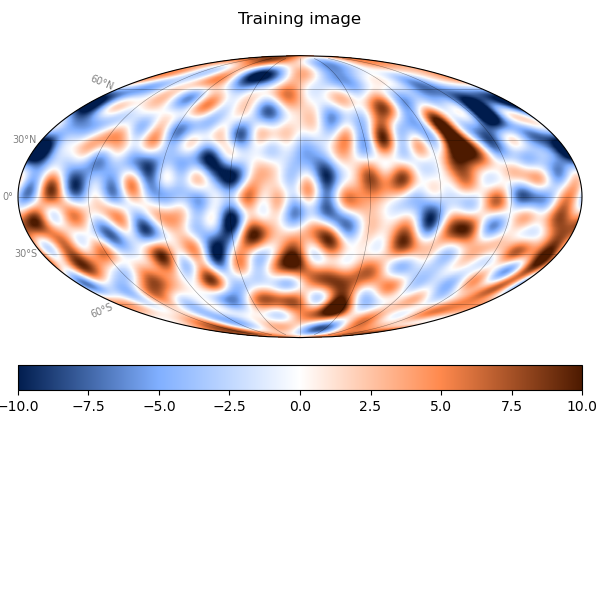


____semi-variogram setup___

Number of data used: 741321
Max data distance: 3.133 km
Lag length chosen: 0.1 km
Number of lags: 62
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


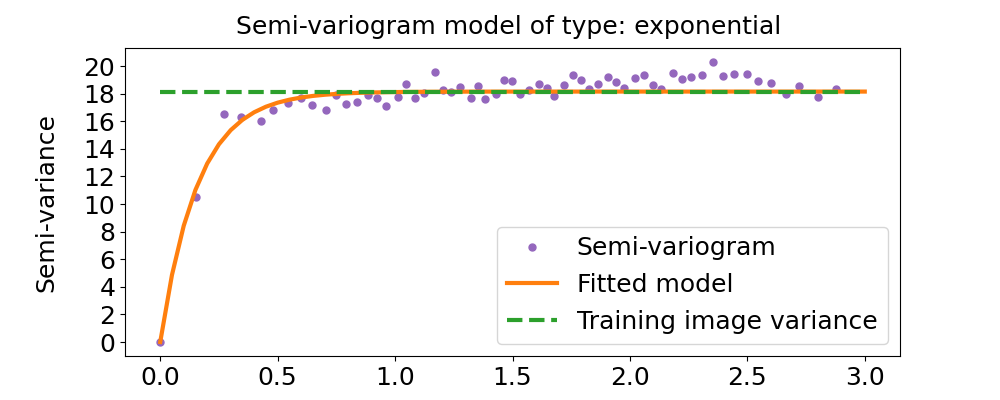

In [4]:
# Generate surface prior object
surface = SDSS(comment, N_SH = shn, sim_type = "core")
surface.grid_glq(nmax = shn, r_at = glq_r)
grid_in = np.array([surface.grid_phi, 90-surface.grid_theta]).T
surface.make_grid(glq_r, grid_in, calc_sph_d = True)

# Set up random surface based on int
rand_int = 251291
clm = pyshtools.SHCoeffs.from_random(power, seed=rand_int)
grid = clm.expand()
coeffs = clm.to_array(lmax=shn)

# Set data from random SH coeffs
surface.data = pyshtools.expand.MakeGridGLQ(coeffs, surface.grid_zero, [surface.grid_nmax, 1, 1, shn, False]).reshape(-1,)
surface.target_var = np.var(surface.data)
surface.target_mean = 0.0
surface.g_prior, surface.g_prior_cilm = mt_util.sh_expand_glq(surface.data, 
                             surface.grid_nmax, surface.grid_w_shtools, surface.grid_zero, 
                             shn, geomag_scale = False)

# Plot surface prior
import importlib
importlib.reload(mt_util)
surface.grid_glq(nmax = 400, r_at = 1.0)
training_image = mt_util.sh_makegrid_glq(surface.g_prior, surface.grid_nmax, surface.grid_zero, 20)
mt_util.plot_global(lat = 90-surface.grid_theta, lon = surface.grid_phi, data=training_image, limits_data = [-10,10],
                title='Training image', savefig = False, save_dpi = 100, save_string ="simple_ex_fisher_TI", save_path = "images/",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4, 
                rasterize = True, point_size=0.1, coast_width = 0.0)
surface.grid_glq(nmax = shn, r_at = glq_r)

# Generate prior conditional dist. and semi-variogram
surface.condtab(normsize=10000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 101, rangv_lim = 2.0, rangv_N = 101)

surface.semivar(model_lags = "all", model = "exponential", max_dist = 20, lag_length = 0.05,
             zero_nugget = True, hit_target_var = True)

#%% PLOT SEMI-VARIOGRAM
fig = plt.figure(figsize=(10,4), dpi = 100) 
plt.plot(surface.lags,surface.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')
plt.plot(surface.lags_sv_curve,surface.sv_curve,color='C1', linewidth = 3,label='Fitted model')
plt.plot(surface.lags_sv_curve,np.ones(surface.lags_sv_curve.shape)*surface.target_var,linewidth = 3,
         color="C2", linestyle="dashed", label="Training image variance")
plt.ylabel('Semi-variance',fontsize=18,labelpad=18)
plt.xlabel('Lag',fontsize=18,labelpad=18)
plt.yticks(np.arange(0,22,2))
plt.title("Semi-variogram model of type: %s " % surface.model_names[surface.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
#fig.savefig('sv_simple_ex.pdf', bbox_inches='tight', dpi = 300)
plt.show()

# Synthetic observations

In [5]:
C_e_const = 10**(-3)

s_obs = SDSS(comment, N_SH = shn, sim_type = "random_obs")

s_obs.grid_equal_area(N_grid = 2000, r_at = 1)

grid_in = np.array([s_obs.grid_phi, 90-s_obs.grid_theta]).T
s_obs.make_grid(1, grid_in)

s_obs.r_grid = np.random.normal(loc=1.2, scale=0.05, size=(s_obs.N_grid,))


<IPython.core.display.Javascript object>


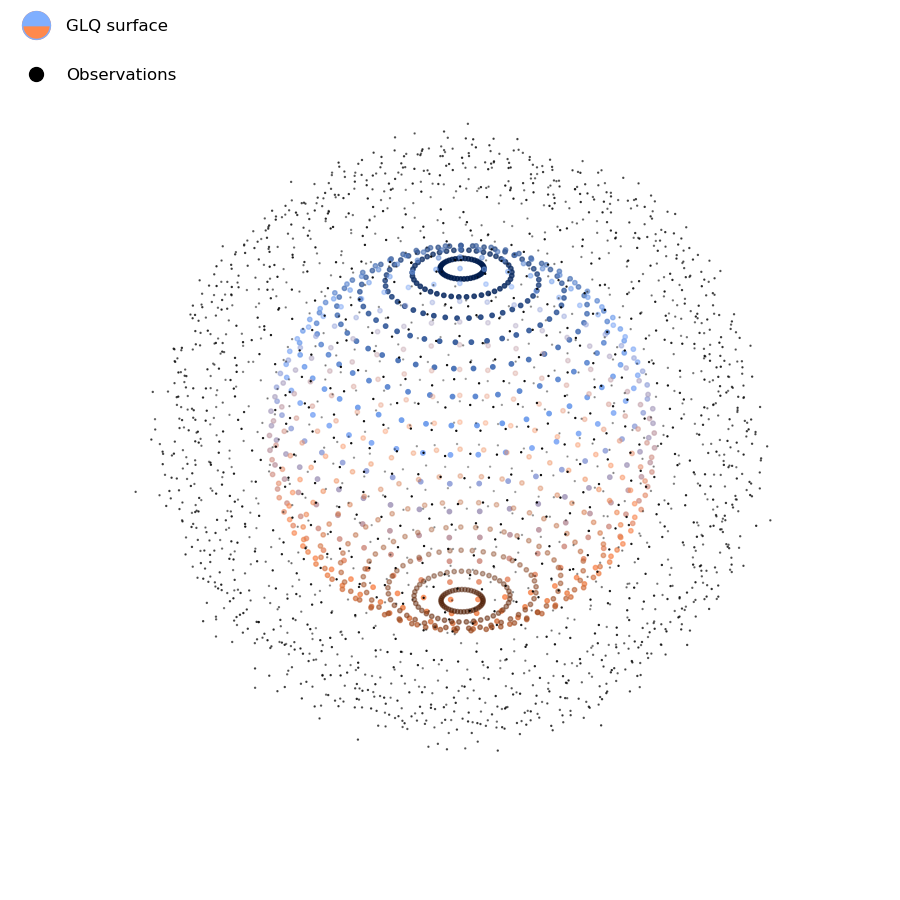

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

surface.grid_glq(nmax = shn, r_at = glq_r)
phi = surface.lon.reshape(surface.grid_nmax+1,2*surface.grid_nmax+1)*np.pi/180
theta = (90 - surface.lat.reshape(surface.grid_nmax+1,2*surface.grid_nmax+1))*np.pi/180

# The Cartesian coordinates of the unit sphere
x = 0.8*np.sin(theta) * np.cos(phi)
y = 0.8*np.sin(theta) * np.sin(phi)
z = 0.8*np.cos(theta)



#rand_size = 500
#phi_d = np.random.uniform(low = -180, high = 180.0, size = rand_size)*np.pi/180
#theta_d = np.random.uniform(low = 0, high = 180.0, size = rand_size)*np.pi/180

phi_d = s_obs.grid_phi*np.pi/180
theta_d = s_obs.grid_theta*np.pi/180

#phi_d = s_sat.lon*np.pi/180
#theta_d = (90 - s_sat.lat)*np.pi/180

#r_rand_u = np.random.uniform(low = 0.8, high = 2, size = rand_size)

r_rand_u = s_obs.r_grid

# The Cartesian coordinates of the unit sphere
x_d = r_rand_u*np.sin(theta_d) * np.cos(phi_d)
y_d = r_rand_u*np.sin(theta_d) * np.sin(phi_d)
z_d = r_rand_u*np.cos(theta_d)


cmap = [(0.0,  0.10980392156862745,  0.30196078431372547), 
                   (0.5019607843137255,  0.6862745098039216,  1.0), 
                   (1.0,  0.5372549019607843,  0.30196078431372547), 
                   (0.30196078431372547,  0.10196078431372549,  0.0)]

cmap = colors.LinearSegmentedColormap.from_list("cmap", cmap, N=1000)


fig = plt.figure(figsize=(9,9), dpi = 100, constrained_layout = True)
#ax = fig.add_subplot(111, projection='3d')

gs = fig.add_gridspec(1, 1, height_ratios=[1], width_ratios=[1]) # Add x-by-y grid
ax = fig.add_subplot(gs[0, 0], projection="3d")


sph_glq = ax.scatter(x, y, z, s = 10, cmap = cmap, c=theta, marker = "o", rasterized = True)

sph_d = ax.scatter(x_d, y_d, z_d, s = 0.5, color = "k", marker = "o", rasterized = True)

# Turn off the axis planes
ax.set_axis_off()

ax.view_init(elev=30., azim=30)
ax.set_xlim3d(-1, 1)     
ax.set_ylim3d(-1, 1) 
ax.set_zlim3d(-1, 1)

#---- Define First Legend Entry ----

m1, = ax.plot([], [], c=(0.5019607843137255,  0.6862745098039216,  1.0) , marker='o', markersize=20,
              fillstyle='top', linestyle='none')
m2, = ax.plot([], [], c=(1.0,  0.5372549019607843,  0.30196078431372547) , marker='o', markersize=20,
              fillstyle='bottom', linestyle='none')

#---- Define Second Legend Entry ----

m3, = ax.plot([], [], c='k' , marker='o', markersize=10, linestyle='none')

#---- Plot Legend ----

plt.legend(((m2, m1), (m3)), ('GLQ surface', 'Observations'), numpoints=1, labelspacing=2,
          loc='upper left', fontsize=12, frameon=False)


#fig.subplots_adjust(left=0.03, bottom=0.1, right=0.97, top=0.9, wspace = 0.0, hspace=0.0)

#fig.savefig('implementation_geometry_simple_ex.pdf', bbox_inches='tight', dpi = 300) 

#plt.legend()
plt.show()

# Fisher forward operator

<IPython.core.display.Javascript object>


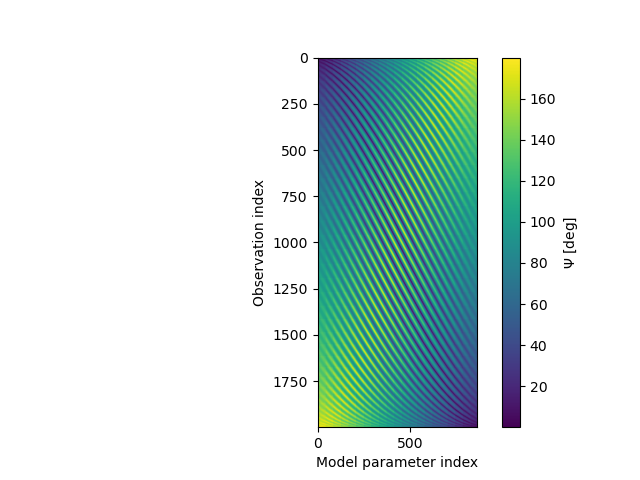

In [7]:
theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [surface.grid_theta.reshape(1,-1), s_obs.grid_theta.reshape(-1,1), 
                                      surface.grid_phi.reshape(1,-1), s_obs.grid_phi.reshape(-1,1)])

angdist = np.arccos(np.cos(theta_d)*np.cos(theta_s)+np.multiply(np.sin(theta_d)@np.sin(theta_s),np.cos(phi_d-phi_s)))

plt.figure()
plt.imshow(angdist*180/np.pi)
plt.colorbar(label="$\Psi$ [deg]")
plt.xlabel("Model parameter index")
plt.ylabel("Observation index")
plt.show()

<IPython.core.display.Javascript object>


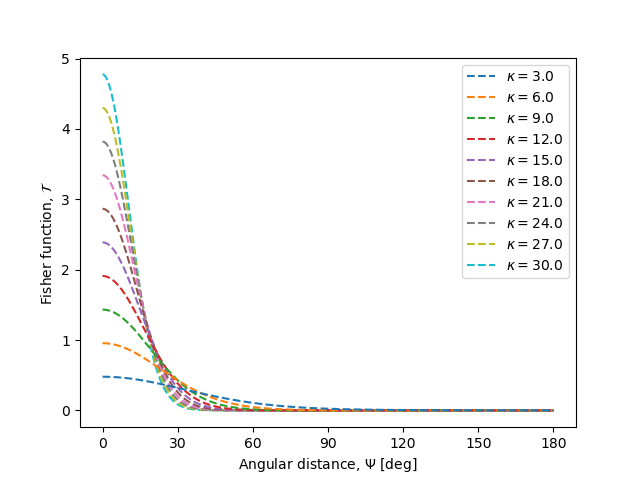

In [8]:
angdist_func = np.linspace(0,np.pi,10000)

plt.figure(dpi=100)
for kappa_func in np.linspace(3,30,10):
    kappa_func = np.round(kappa_func)
    Tau_func = kappa_func/(4*np.pi*np.sinh(kappa_func))*np.exp(kappa_func*np.cos(angdist_func))
    plt.plot(angdist_func*180/np.pi,Tau_func, label = "$\kappa = ${}".format(kappa_func),zorder=1/kappa_func,linestyle="dashed")
plt.xlabel("Angular distance, $\Psi$ [deg]")
plt.ylabel("Fisher function, $\mathcal{T}$")
plt.xticks(np.arange(0,180+30,step=30))
plt.legend()
#plt.savefig('fisher_kappas.pdf', bbox_inches='tight', dpi = 300) 
plt.show()

<IPython.core.display.Javascript object>


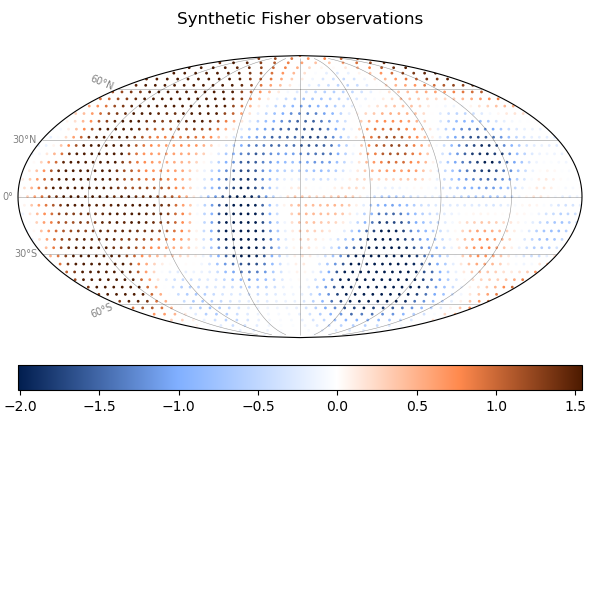

In [9]:
kappa = 15
Tau = 1/s_obs.r_grid.reshape(-1,1)*kappa/(4*np.pi*np.sinh(kappa))*np.exp(kappa*np.cos(angdist))
Tau.shape

# Generate forward operator and covariances based on prior object
surface.G = np.pi/(surface.grid_nmax+0.5)*np.multiply(surface.grid_w,Tau) # +0.5 for parity with SHTOOLS

C_e = np.diag(C_e_const**2*np.ones(s_obs.N_grid,)) # No need to store C_e outside of here

surface.C_mm_all = surface.target_var-surface.sv_lut

surface.C_dm_all = surface.G@surface.C_mm_all

surface.C_dd = surface.C_dm_all@surface.G.T  + C_e

surface.C_dm_all = surface.C_dm_all.T

surface.C_e_const = C_e_const


# Use forward operator to generate synthetic truth observations based on synthetic truth object
s_obs.data = surface.G@surface_t.data
s_obs.data += np.random.normal(scale = C_e_const, size = s_obs.data.shape)

# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

mt_util.plot_global(lat = s_obs.lat, lon = s_obs.lon, data=s_obs.data, 
                cbar_h = 0.075, cbar_even = False, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "", figsize=(6,6), coast_width = 0.0,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Synthetic Fisher observations', point_size=1,
                savefig = False, save_dpi = 100, save_string ="simple_ex_fischer_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# Unconditional simulation

In [10]:
surface_uncon = deepcopy(surface)

In [11]:
N_sim = 1000

surface_uncon.run_sim(N_sim, surface_uncon.grid_N, surface_uncon.C_mm_all, surface_uncon.C_dd,
        surface_uncon.C_dm_all, surface_uncon.G,
        s_obs.data, surface_uncon.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = True, solve_cho=True)

 |OO--------| 27.6%   realization nr. 0. Counter: 238/861, Running error magnitude: 0.5

 |OOOO------| 41.0%   realization nr. 0. Counter: 353/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.968 seconds 
Total elapsed time: 0.066 minutes 
Variance: 18.342
Mean: -0.177
Max: 12.757
Min: -14.688
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.944 seconds 
Total elapsed time: 0.132 minutes 
Variance: 16.003
Mean: 0.766
Max: 11.777
Min: -14.075
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.976 seconds 
Total elapsed time: 0.198 minutes 
Variance: 19.383
Mean: 0.437
Max: 13.237
Min: -14.958
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.940 seconds 
Total elapsed time: 0.264 minutes 
Variance: 20.939
Mean: 0.620
Max: 13.115
Min: -14.776
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr. 4. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.908 seconds 
Total elapsed time: 0.329

 |OO--------| 26.8%   realization nr. 38. Counter: 231/861, Running error magnitude: 0.5

 |OOO-------| 39.1%   realization nr. 38. Counter: 337/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 38. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.873 seconds 
Total elapsed time: 2.560 minutes 
Variance: 17.898
Mean: 1.105
Max: 12.291
Min: -14.973
Run nr.: 39

 |OOOOOOOOOO| 100.0%   realization nr. 39. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.849 seconds 
Total elapsed time: 2.624 minutes 
Variance: 18.064
Mean: 0.253
Max: 12.503
Min: -14.530
Run nr.: 40

 |OOOOOOOOOO| 100.0%   realization nr. 40. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.947 seconds 
Total elapsed time: 2.690 minutes 
Variance: 18.125
Mean: 0.200
Max: 12.231
Min: -15.086
Run nr.: 41

 |OOOOOOOOOO| 100.0%   realization nr. 41. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.956 seconds 
Total elapsed time: 2.756 minutes 
Variance: 16.815
Mean: 0.601
Max: 12.724
Min: -14.640
Run nr.: 42

 |OOOOOOOOOO| 100.0%   realization nr. 42. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.980 seconds 
Total elapsed tim

 |OO--------| 20.4%   realization nr. 76. Counter: 176/861, Running error magnitude: 0.5

 |OOO-------| 36.6%   realization nr. 76. Counter: 315/861, Running error magnitude: 0.5

 |OOOO------| 48.4%   realization nr. 76. Counter: 417/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 76. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.831 seconds 
Total elapsed time: 5.035 minutes 
Variance: 16.984
Mean: -0.570
Max: 12.379
Min: -14.902
Run nr.: 77

 |OOOOOOOOOO| 100.0%   realization nr. 77. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.835 seconds 
Total elapsed time: 5.099 minutes 
Variance: 19.056
Mean: -1.198
Max: 10.928
Min: -14.996
Run nr.: 78

 |OOOOOOOOOO| 100.0%   realization nr. 78. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.825 seconds 
Total elapsed time: 5.162 minutes 
Variance: 16.049
Mean: -0.124
Max: 11.990
Min: -15.100
Run nr.: 79

 |OOOOOOOOOO| 100.0%   realization nr. 79. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.870 seconds 
Total elapsed time: 5.227 minutes 
Variance: 21.214
Mean: 0.672
Max: 13.163
Min: -14.518
Run nr.: 80

 |OOOOOOOOOO| 100.0%   realization nr. 80. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.781 seconds 
Total elapsed 

 |OO--------| 21.8%   realization nr. 114. Counter: 188/861, Running error magnitude: 0.5

 |OOO-------| 38.2%   realization nr. 114. Counter: 329/861, Running error magnitude: 0.5

 |OOOO------| 49.1%   realization nr. 114. Counter: 423/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 114. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.921 seconds 
Total elapsed time: 7.508 minutes 
Variance: 17.866
Mean: -0.559
Max: 12.928
Min: -15.193
Run nr.: 115

 |OOOOOOOOOO| 100.0%   realization nr. 115. Counter: 861/861, Running error magnitude: 0.5
Run time: 4.038 seconds 
Total elapsed time: 7.575 minutes 
Variance: 22.758
Mean: 0.522
Max: 13.224
Min: -14.859
Run nr.: 116

 |OOOOOOOOOO| 100.0%   realization nr. 116. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.994 seconds 
Total elapsed time: 7.642 minutes 
Variance: 22.220
Mean: -0.293
Max: 13.112
Min: -15.250
Run nr.: 117

 |OOOOOOOOOO| 100.0%   realization nr. 117. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.976 seconds 
Total elapsed time: 7.708 minutes 
Variance: 17.984
Mean: 0.553
Max: 12.145
Min: -14.838
Run nr.: 118

 |OOOOOOOOOO| 100.0%   realization nr. 118. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.864 seconds 
Total 

 |OOO-------| 36.9%   realization nr. 151. Counter: 318/861, Running error magnitude: 0.5

 |OOOO------| 48.7%   realization nr. 151. Counter: 419/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 151. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.887 seconds 
Total elapsed time: 9.952 minutes 
Variance: 14.199
Mean: -0.634
Max: 10.382
Min: -14.332
Run nr.: 152

 |OOOOOOOOOO| 100.0%   realization nr. 152. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.821 seconds 
Total elapsed time: 10.016 minutes 
Variance: 14.899
Mean: 0.439
Max: 12.070
Min: -13.772
Run nr.: 153

 |OOOOOOOOOO| 100.0%   realization nr. 153. Counter: 861/861, Running error magnitude: 0.5
Run time: 4.032 seconds 
Total elapsed time: 10.083 minutes 
Variance: 17.062
Mean: 0.733
Max: 13.126
Min: -11.998
Run nr.: 154

 |OOOOOOOOOO| 100.0%   realization nr. 154. Counter: 861/861, Running error magnitude: 0.6
Run time: 3.821 seconds 
Total elapsed time: 10.147 minutes 
Variance: 19.728
Mean: 0.065
Max: 13.067
Min: -15.023
Run nr.: 155

 |OOOOOOOOOO| 100.0%   realization nr. 155. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.902 seconds 
Tota

 |OOOO------| 40.2%   realization nr. 188. Counter: 346/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 188. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.834 seconds 
Total elapsed time: 12.364 minutes 
Variance: 15.939
Mean: 0.258
Max: 13.203
Min: -11.215
Run nr.: 189

 |OOOOOOOOOO| 100.0%   realization nr. 189. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.960 seconds 
Total elapsed time: 12.430 minutes 
Variance: 18.853
Mean: 0.330
Max: 13.269
Min: -15.098
Run nr.: 190

 |OOOOOOOOOO| 100.0%   realization nr. 190. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.841 seconds 
Total elapsed time: 12.494 minutes 
Variance: 17.118
Mean: 0.215
Max: 12.197
Min: -14.873
Run nr.: 191

 |OOOOOOOOOO| 100.0%   realization nr. 191. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.938 seconds 
Total elapsed time: 12.559 minutes 
Variance: 16.816
Mean: 0.241
Max: 12.161
Min: -14.349
Run nr.: 192

 |OOOOOOOOOO| 100.0%   realization nr. 192. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.883 seconds 
Tota

 |OOO-------| 39.5%   realization nr. 225. Counter: 340/861, Running error magnitude: 0.5

 |OOOOO-----| 50.3%   realization nr. 225. Counter: 433/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 225. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.768 seconds 
Total elapsed time: 14.757 minutes 
Variance: 17.733
Mean: 0.394
Max: 11.851
Min: -14.657
Run nr.: 226

 |OOOOOOOOOO| 100.0%   realization nr. 226. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.914 seconds 
Total elapsed time: 14.822 minutes 
Variance: 16.734
Mean: -0.033
Max: 12.847
Min: -12.249
Run nr.: 227

 |OOOOOOOOOO| 100.0%   realization nr. 227. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.901 seconds 
Total elapsed time: 14.887 minutes 
Variance: 20.085
Mean: -0.740
Max: 12.501
Min: -14.612
Run nr.: 228

 |OOOOOOOOOO| 100.0%   realization nr. 228. Counter: 861/861, Running error magnitude: 0.4
Run time: 3.798 seconds 
Total elapsed time: 14.951 minutes 
Variance: 15.910
Mean: -0.059
Max: 13.148
Min: -14.785
Run nr.: 229

 |OOOOOOOOOO| 100.0%   realization nr. 229. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.821 seconds 
T

 |OOO-------| 39.3%   realization nr. 262. Counter: 338/861, Running error magnitude: 0.4

 |OOOO------| 49.9%   realization nr. 262. Counter: 430/861, Running error magnitude: 0.4

 |OOOOOOOOOO| 100.0%   realization nr. 262. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.874 seconds 
Total elapsed time: 17.147 minutes 
Variance: 15.553
Mean: 0.695
Max: 12.793
Min: -14.865
Run nr.: 263

 |OOOOOOOOOO| 100.0%   realization nr. 263. Counter: 861/861, Running error magnitude: 0.5
Run time: 4.100 seconds 
Total elapsed time: 17.215 minutes 
Variance: 18.877
Mean: 0.566
Max: 12.689
Min: -13.176
Run nr.: 264

 |OOOOOOOOOO| 100.0%   realization nr. 264. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.898 seconds 
Total elapsed time: 17.280 minutes 
Variance: 17.463
Mean: 0.065
Max: 12.859
Min: -14.320
Run nr.: 265

 |OOOOOOOOOO| 100.0%   realization nr. 265. Counter: 861/861, Running error magnitude: 0.5
Run time: 4.095 seconds 
Total elapsed time: 17.348 minutes 
Variance: 17.450
Mean: -0.166
Max: 12.742
Min: -14.348
Run nr.: 266

 |OOOOOOOOOO| 100.0%   realization nr. 266. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.929 seconds 
Tot

 |OOO-------| 36.8%   realization nr. 299. Counter: 317/861, Running error magnitude: 0.5

 |OOOO------| 48.4%   realization nr. 299. Counter: 417/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 299. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.949 seconds 
Total elapsed time: 19.555 minutes 
Variance: 18.165
Mean: -0.176
Max: 10.906
Min: -13.840
Run nr.: 300

 |OOOOOOOOOO| 100.0%   realization nr. 300. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.931 seconds 
Total elapsed time: 19.621 minutes 
Variance: 17.000
Mean: -0.486
Max: 12.929
Min: -14.257
Run nr.: 301

 |OOOOOOOOOO| 100.0%   realization nr. 301. Counter: 861/861, Running error magnitude: 0.5
Run time: 4.039 seconds 
Total elapsed time: 19.688 minutes 
Variance: 16.038
Mean: 0.416
Max: 12.469
Min: -13.559
Run nr.: 302

 |OOOOOOOOOO| 100.0%   realization nr. 302. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.878 seconds 
Total elapsed time: 19.753 minutes 
Variance: 16.252
Mean: 0.192
Max: 12.561
Min: -14.310
Run nr.: 303

 |OOOOOOOOOO| 100.0%   realization nr. 303. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.975 seconds 
To

 |OOO-------| 35.9%   realization nr. 336. Counter: 309/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 336. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.886 seconds 
Total elapsed time: 21.947 minutes 
Variance: 13.133
Mean: -0.524
Max: 10.694
Min: -12.667
Run nr.: 337

 |OOOOOOOOOO| 100.0%   realization nr. 337. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.915 seconds 
Total elapsed time: 22.012 minutes 
Variance: 17.177
Mean: 0.517
Max: 12.985
Min: -14.625
Run nr.: 338

 |OOOOOOOOOO| 100.0%   realization nr. 338. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.834 seconds 
Total elapsed time: 22.076 minutes 
Variance: 21.011
Mean: 0.741
Max: 13.690
Min: -14.285
Run nr.: 339

 |OOOOOOOOOO| 100.0%   realization nr. 339. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.811 seconds 
Total elapsed time: 22.140 minutes 
Variance: 17.321
Mean: 0.926
Max: 12.801
Min: -14.734
Run nr.: 340

 |OOOOOOOOOO| 100.0%   realization nr. 340. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.971 seconds 
Tot

 |OOO-------| 37.7%   realization nr. 373. Counter: 325/861, Running error magnitude: 0.5

 |OOOO------| 48.7%   realization nr. 373. Counter: 419/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 373. Counter: 861/861, Running error magnitude: 0.5
Run time: 4.004 seconds 
Total elapsed time: 24.365 minutes 
Variance: 17.776
Mean: 0.111
Max: 11.847
Min: -14.578
Run nr.: 374

 |OOOOOOOOOO| 100.0%   realization nr. 374. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.901 seconds 
Total elapsed time: 24.430 minutes 
Variance: 16.850
Mean: 0.775
Max: 12.276
Min: -15.059
Run nr.: 375

 |OOOOOOOOOO| 100.0%   realization nr. 375. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.817 seconds 
Total elapsed time: 24.493 minutes 
Variance: 21.341
Mean: -0.315
Max: 12.928
Min: -15.052
Run nr.: 376

 |OOOOOOOOOO| 100.0%   realization nr. 376. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.969 seconds 
Total elapsed time: 24.559 minutes 
Variance: 17.294
Mean: 0.045
Max: 11.777
Min: -15.106
Run nr.: 377

 |OOOOOOOOOO| 100.0%   realization nr. 377. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.986 seconds 
Tot

 |OOOO------| 42.0%   realization nr. 410. Counter: 362/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 410. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.718 seconds 
Total elapsed time: 26.681 minutes 
Variance: 17.711
Mean: 0.446
Max: 13.048
Min: -12.586
Run nr.: 411

 |OOOOOOOOOO| 100.0%   realization nr. 411. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.805 seconds 
Total elapsed time: 26.727 minutes 
Variance: 19.967
Mean: 1.060
Max: 13.186
Min: -14.771
Run nr.: 412

 |OOOOOOOOOO| 100.0%   realization nr. 412. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.769 seconds 
Total elapsed time: 26.774 minutes 
Variance: 16.183
Mean: -0.030
Max: 12.082
Min: -14.453
Run nr.: 413

 |OOOOOOOOOO| 100.0%   realization nr. 413. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.738 seconds 
Total elapsed time: 26.819 minutes 
Variance: 17.924
Mean: 0.109
Max: 12.018
Min: -14.516
Run nr.: 414

 |OOOOOOOOOO| 100.0%   realization nr. 414. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.683 seconds 
Tot

 |OOO-------| 38.8%   realization nr. 447. Counter: 334/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 447. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.010 seconds 
Total elapsed time: 28.406 minutes 
Variance: 16.345
Mean: -0.062
Max: 11.930
Min: -15.141
Run nr.: 448

 |OOOOOOOOOO| 100.0%   realization nr. 448. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.901 seconds 
Total elapsed time: 28.455 minutes 
Variance: 19.890
Mean: 0.101
Max: 12.732
Min: -14.696
Run nr.: 449

 |OOOOOOOOOO| 100.0%   realization nr. 449. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.859 seconds 
Total elapsed time: 28.502 minutes 
Variance: 18.485
Mean: 0.099
Max: 12.790
Min: -15.220
Run nr.: 450

 |OOOOOOOOOO| 100.0%   realization nr. 450. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.813 seconds 
Total elapsed time: 28.549 minutes 
Variance: 15.698
Mean: 0.383
Max: 13.175
Min: -14.574
Run nr.: 451

 |OOOOOOOOOO| 100.0%   realization nr. 451. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.737 seconds 
Tot

 |OOO-------| 37.5%   realization nr. 484. Counter: 323/861, Running error magnitude: 0.5

 |OOOO------| 48.4%   realization nr. 484. Counter: 417/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 484. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.796 seconds 
Total elapsed time: 30.159 minutes 
Variance: 18.708
Mean: -0.140
Max: 12.854
Min: -14.721
Run nr.: 485

 |OOOOOOOOOO| 100.0%   realization nr. 485. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.653 seconds 
Total elapsed time: 30.203 minutes 
Variance: 17.604
Mean: -0.692
Max: 12.131
Min: -14.213
Run nr.: 486

 |OOOOOOOOOO| 100.0%   realization nr. 486. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.822 seconds 
Total elapsed time: 30.250 minutes 
Variance: 16.370
Mean: -0.237
Max: 12.008
Min: -14.701
Run nr.: 487

 |OOOOOOOOOO| 100.0%   realization nr. 487. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.822 seconds 
Total elapsed time: 30.297 minutes 
Variance: 15.643
Mean: -0.467
Max: 12.820
Min: -14.281
Run nr.: 488

 |OOOOOOOOOO| 100.0%   realization nr. 488. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.820 seconds 


 |OOOO------| 42.2%   realization nr. 521. Counter: 363/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 521. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.715 seconds 
Total elapsed time: 31.869 minutes 
Variance: 17.061
Mean: -0.000
Max: 12.488
Min: -14.947
Run nr.: 522

 |OOOOOOOOOO| 100.0%   realization nr. 522. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.744 seconds 
Total elapsed time: 31.915 minutes 
Variance: 19.354
Mean: 0.012
Max: 12.912
Min: -15.124
Run nr.: 523

 |OOOOOOOOOO| 100.0%   realization nr. 523. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.730 seconds 
Total elapsed time: 31.960 minutes 
Variance: 16.240
Mean: -0.669
Max: 12.559
Min: -14.214
Run nr.: 524

 |OOOOOOOOOO| 100.0%   realization nr. 524. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.725 seconds 
Total elapsed time: 32.006 minutes 
Variance: 18.232
Mean: -0.842
Max: 12.601
Min: -14.957
Run nr.: 525

 |OOOOOOOOOO| 100.0%   realization nr. 525. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.955 seconds 
T

 |OOOO------| 40.9%   realization nr. 558. Counter: 352/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 558. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.938 seconds 
Total elapsed time: 33.614 minutes 
Variance: 15.834
Mean: 0.579
Max: 13.247
Min: -13.125
Run nr.: 559

 |OOOOOOOOOO| 100.0%   realization nr. 559. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.730 seconds 
Total elapsed time: 33.660 minutes 
Variance: 17.965
Mean: -0.617
Max: 12.560
Min: -14.205
Run nr.: 560

 |OOOOOOOOOO| 100.0%   realization nr. 560. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.685 seconds 
Total elapsed time: 33.704 minutes 
Variance: 20.754
Mean: 0.028
Max: 12.839
Min: -14.311
Run nr.: 561

 |OOOOOOOOOO| 100.0%   realization nr. 561. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.785 seconds 
Total elapsed time: 33.751 minutes 
Variance: 18.453
Mean: 0.443
Max: 13.182
Min: -11.323
Run nr.: 562

 |OOOOOOOOOO| 100.0%   realization nr. 562. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.763 seconds 
Tot

 |OOO-------| 38.9%   realization nr. 595. Counter: 335/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 595. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.910 seconds 
Total elapsed time: 35.355 minutes 
Variance: 16.491
Mean: 0.164
Max: 12.545
Min: -14.274
Run nr.: 596

 |OOOOOOOOOO| 100.0%   realization nr. 596. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.846 seconds 
Total elapsed time: 35.403 minutes 
Variance: 17.164
Mean: 0.093
Max: 13.175
Min: -14.734
Run nr.: 597

 |OOOOOOOOOO| 100.0%   realization nr. 597. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.833 seconds 
Total elapsed time: 35.450 minutes 
Variance: 17.567
Mean: 0.072
Max: 12.950
Min: -13.906
Run nr.: 598

 |OOOOOOOOOO| 100.0%   realization nr. 598. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.947 seconds 
Total elapsed time: 35.499 minutes 
Variance: 17.218
Mean: -0.659
Max: 11.707
Min: -14.606
Run nr.: 599

 |OOOOOOOOOO| 100.0%   realization nr. 599. Counter: 861/861, Running error magnitude: 0.5
Run time: 3.055 seconds 
Tot

 |OOO-------| 39.1%   realization nr. 632. Counter: 337/861, Running error magnitude: 0.5

 |OOOOO-----| 50.3%   realization nr. 632. Counter: 433/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 632. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.870 seconds 
Total elapsed time: 37.108 minutes 
Variance: 17.070
Mean: 0.395
Max: 13.034
Min: -13.098
Run nr.: 633

 |OOOOOOOOOO| 100.0%   realization nr. 633. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.799 seconds 
Total elapsed time: 37.154 minutes 
Variance: 15.710
Mean: -0.436
Max: 10.653
Min: -14.699
Run nr.: 634

 |OOOOOOOOOO| 100.0%   realization nr. 634. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.775 seconds 
Total elapsed time: 37.201 minutes 
Variance: 16.530
Mean: -0.418
Max: 13.291
Min: -14.626
Run nr.: 635

 |OOOOOOOOOO| 100.0%   realization nr. 635. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.734 seconds 
Total elapsed time: 37.246 minutes 
Variance: 15.330
Mean: -1.185
Max: 9.604
Min: -14.146
Run nr.: 636

 |OOOOOOOOOO| 100.0%   realization nr. 636. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.940 seconds 
To

 |OOO-------| 39.0%   realization nr. 669. Counter: 336/861, Running error magnitude: 0.5

 |OOOOO-----| 50.1%   realization nr. 669. Counter: 431/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 669. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.747 seconds 
Total elapsed time: 38.835 minutes 
Variance: 19.035
Mean: 0.053
Max: 12.927
Min: -15.190
Run nr.: 670

 |OOOOOOOOOO| 100.0%   realization nr. 670. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.781 seconds 
Total elapsed time: 38.881 minutes 
Variance: 18.854
Mean: -0.047
Max: 12.990
Min: -13.057
Run nr.: 671

 |OOOOOOOOOO| 100.0%   realization nr. 671. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.750 seconds 
Total elapsed time: 38.927 minutes 
Variance: 18.082
Mean: 0.447
Max: 12.626
Min: -14.796
Run nr.: 672

 |OOOOOOOOOO| 100.0%   realization nr. 672. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.730 seconds 
Total elapsed time: 38.972 minutes 
Variance: 17.448
Mean: -0.357
Max: 12.659
Min: -14.914
Run nr.: 673

 |OOOOOOOOOO| 100.0%   realization nr. 673. Counter: 861/861, Running error magnitude: 0.4
Run time: 2.793 seconds 
To

 |OOOO------| 40.4%   realization nr. 706. Counter: 348/861, Running error magnitude: 0.5

 |OOOOO-----| 51.2%   realization nr. 706. Counter: 441/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 706. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.926 seconds 
Total elapsed time: 40.568 minutes 
Variance: 17.754
Mean: 1.020
Max: 12.586
Min: -14.025
Run nr.: 707

 |OOOOOOOOOO| 100.0%   realization nr. 707. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.915 seconds 
Total elapsed time: 40.617 minutes 
Variance: 15.433
Mean: 0.204
Max: 12.395
Min: -13.289
Run nr.: 708

 |OOOOOOOOOO| 100.0%   realization nr. 708. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.890 seconds 
Total elapsed time: 40.665 minutes 
Variance: 21.127
Mean: 0.801
Max: 12.663
Min: -14.336
Run nr.: 709

 |OOOOOOOOOO| 100.0%   realization nr. 709. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.746 seconds 
Total elapsed time: 40.711 minutes 
Variance: 18.647
Mean: 0.241
Max: 11.599
Min: -15.021
Run nr.: 710

 |OOOOOOOOOO| 100.0%   realization nr. 710. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.780 seconds 
Tota

 |OOOO------| 41.6%   realization nr. 743. Counter: 358/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 743. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.765 seconds 
Total elapsed time: 42.297 minutes 
Variance: 17.601
Mean: -0.978
Max: 8.143
Min: -14.946
Run nr.: 744

 |OOOOOOOOOO| 100.0%   realization nr. 744. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.787 seconds 
Total elapsed time: 42.343 minutes 
Variance: 19.579
Mean: 0.034
Max: 12.201
Min: -15.067
Run nr.: 745

 |OOOOOOOOOO| 100.0%   realization nr. 745. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.809 seconds 
Total elapsed time: 42.390 minutes 
Variance: 17.076
Mean: -0.444
Max: 12.854
Min: -15.095
Run nr.: 746

 |OOOOOOOOOO| 100.0%   realization nr. 746. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.745 seconds 
Total elapsed time: 42.436 minutes 
Variance: 18.392
Mean: 0.360
Max: 12.691
Min: -14.922
Run nr.: 747

 |OOOOOOOOOO| 100.0%   realization nr. 747. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.770 seconds 
Tot

 |OOOO------| 41.8%   realization nr. 780. Counter: 360/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 780. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.664 seconds 
Total elapsed time: 44.036 minutes 
Variance: 15.348
Mean: -0.266
Max: 13.186
Min: -12.931
Run nr.: 781

 |OOOOOOOOOO| 100.0%   realization nr. 781. Counter: 861/861, Running error magnitude: 0.4
Run time: 2.843 seconds 
Total elapsed time: 44.083 minutes 
Variance: 14.619
Mean: -0.226
Max: 11.312
Min: -13.273
Run nr.: 782

 |OOOOOOOOOO| 100.0%   realization nr. 782. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.783 seconds 
Total elapsed time: 44.129 minutes 
Variance: 16.013
Mean: -0.715
Max: 11.045
Min: -15.102
Run nr.: 783

 |OOOOOOOOOO| 100.0%   realization nr. 783. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.866 seconds 
Total elapsed time: 44.177 minutes 
Variance: 17.155
Mean: -1.166
Max: 12.818
Min: -15.078
Run nr.: 784

 |OOOOOOOOOO| 100.0%   realization nr. 784. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.995 seconds 


 |OOO-------| 38.7%   realization nr. 817. Counter: 333/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 817. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.799 seconds 
Total elapsed time: 45.793 minutes 
Variance: 16.575
Mean: 0.051
Max: 13.024
Min: -13.427
Run nr.: 818

 |OOOOOOOOOO| 100.0%   realization nr. 818. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.832 seconds 
Total elapsed time: 45.840 minutes 
Variance: 18.817
Mean: 0.236
Max: 12.820
Min: -14.021
Run nr.: 819

 |OOOOOOOOOO| 100.0%   realization nr. 819. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.817 seconds 
Total elapsed time: 45.887 minutes 
Variance: 19.216
Mean: -1.095
Max: 11.354
Min: -15.209
Run nr.: 820

 |OOOOOOOOOO| 100.0%   realization nr. 820. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.828 seconds 
Total elapsed time: 45.934 minutes 
Variance: 14.882
Mean: 0.018
Max: 12.603
Min: -15.223
Run nr.: 821

 |OOOOOOOOOO| 100.0%   realization nr. 821. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.731 seconds 
Tot

 |OOOO------| 41.3%   realization nr. 854. Counter: 356/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 854. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.738 seconds 
Total elapsed time: 47.538 minutes 
Variance: 18.725
Mean: -0.926
Max: 13.031
Min: -14.825
Run nr.: 855

 |OOOOOOOOOO| 100.0%   realization nr. 855. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.770 seconds 
Total elapsed time: 47.584 minutes 
Variance: 15.993
Mean: -0.311
Max: 10.997
Min: -13.903
Run nr.: 856

 |OOOOOOOOOO| 100.0%   realization nr. 856. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.919 seconds 
Total elapsed time: 47.633 minutes 
Variance: 15.524
Mean: 0.501
Max: 12.351
Min: -14.116
Run nr.: 857

 |OOOOOOOOOO| 100.0%   realization nr. 857. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.833 seconds 
Total elapsed time: 47.680 minutes 
Variance: 19.254
Mean: -0.421
Max: 13.082
Min: -14.613
Run nr.: 858

 |OOOOOOOOOO| 100.0%   realization nr. 858. Counter: 861/861, Running error magnitude: 0.4
Run time: 2.805 seconds 
T

 |OOO-------| 37.9%   realization nr. 891. Counter: 326/861, Running error magnitude: 0.5

 |OOOO------| 49.5%   realization nr. 891. Counter: 426/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 891. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.980 seconds 
Total elapsed time: 49.285 minutes 
Variance: 15.605
Mean: 0.459
Max: 12.912
Min: -13.835
Run nr.: 892

 |OOOOOOOOOO| 100.0%   realization nr. 892. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.757 seconds 
Total elapsed time: 49.331 minutes 
Variance: 16.554
Mean: -0.582
Max: 12.940
Min: -14.689
Run nr.: 893

 |OOOOOOOOOO| 100.0%   realization nr. 893. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.732 seconds 
Total elapsed time: 49.377 minutes 
Variance: 18.200
Mean: 0.986
Max: 13.015
Min: -15.104
Run nr.: 894

 |OOOOOOOOOO| 100.0%   realization nr. 894. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.915 seconds 
Total elapsed time: 49.425 minutes 
Variance: 17.728
Mean: 0.366
Max: 13.046
Min: -13.193
Run nr.: 895

 |OOOOOOOOOO| 100.0%   realization nr. 895. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.903 seconds 
Tot

 |OOOO------| 40.1%   realization nr. 928. Counter: 345/861, Running error magnitude: 0.5

 |OOOOOOOOOO| 100.0%   realization nr. 928. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.838 seconds 
Total elapsed time: 51.047 minutes 
Variance: 18.484
Mean: 0.489
Max: 13.078
Min: -14.839
Run nr.: 929

 |OOOOOOOOOO| 100.0%   realization nr. 929. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.771 seconds 
Total elapsed time: 51.093 minutes 
Variance: 16.732
Mean: 0.512
Max: 12.444
Min: -12.182
Run nr.: 930

 |OOOOOOOOOO| 100.0%   realization nr. 930. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.839 seconds 
Total elapsed time: 51.141 minutes 
Variance: 15.471
Mean: 0.754
Max: 12.916
Min: -14.730
Run nr.: 931

 |OOOOOOOOOO| 100.0%   realization nr. 931. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.775 seconds 
Total elapsed time: 51.187 minutes 
Variance: 20.437
Mean: -1.091
Max: 12.676
Min: -14.229
Run nr.: 932

 |OOOOOOOOOO| 100.0%   realization nr. 932. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.935 seconds 
Tot

 |OOO-------| 39.4%   realization nr. 965. Counter: 339/861, Running error magnitude: 0.4

 |OOOOOOOOOO| 100.0%   realization nr. 965. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.848 seconds 
Total elapsed time: 52.799 minutes 
Variance: 16.084
Mean: 0.701
Max: 13.098
Min: -14.765
Run nr.: 966

 |OOOOOOOOOO| 100.0%   realization nr. 966. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.894 seconds 
Total elapsed time: 52.847 minutes 
Variance: 15.328
Mean: 0.111
Max: 12.475
Min: -14.540
Run nr.: 967

 |OOOOOOOOOO| 100.0%   realization nr. 967. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.833 seconds 
Total elapsed time: 52.894 minutes 
Variance: 16.689
Mean: 0.155
Max: 12.776
Min: -14.953
Run nr.: 968

 |OOOOOOOOOO| 100.0%   realization nr. 968. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.774 seconds 
Total elapsed time: 52.940 minutes 
Variance: 17.950
Mean: -0.217
Max: 12.104
Min: -14.682
Run nr.: 969

 |OOOOOOOOOO| 100.0%   realization nr. 969. Counter: 861/861, Running error magnitude: 0.5
Run time: 2.787 seconds 
Tot

<IPython.core.display.Javascript object>

In [12]:
surface_uncon.realization_to_sh_coeff(1, set_nmax = shn, geomag_scale = False)

In [17]:
#surface_uncon.pickle_save_self(nb_name, name_append = "_unconditional")

# Conditional simulation

In [ ]:
N_sim = 1000

surface.run_sim(N_sim, surface.grid_N, surface.C_mm_all, surface.C_dd, surface.C_dm_all, surface.G,
        s_obs.data, surface.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho=True)

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.325 minutes 
Total elapsed time: 1.325 minutes 
Variance: 18.630
Mean: 0.232
Max: 13.246
Min: -14.618
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.307 minutes 
Total elapsed time: 2.632 minutes 
Variance: 18.102
Mean: 0.245
Max: 12.730
Min: -14.842
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.317 minutes 
Total elapsed time: 3.949 minutes 
Variance: 18.704
Mean: 0.250
Max: 11.908
Min: -15.317
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.307 minutes 
Total elapsed time: 5.257 minutes 
Variance: 17.909
Mean: 0.250
Max: 12.958
Min: -14.762
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr. 4. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.310 minutes 
Total elapsed time: 6.566 

 |OOOOOOOOOO| 100.0%   realization nr. 38. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.310 minutes 
Total elapsed time: 51.313 minutes 
Variance: 18.947
Mean: 0.252
Max: 12.599
Min: -15.826
Run nr.: 39

 |OOOOOOOOOO| 100.0%   realization nr. 39. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.304 minutes 
Total elapsed time: 52.617 minutes 
Variance: 19.012
Mean: 0.252
Max: 13.242
Min: -15.044
Run nr.: 40

 |OOOOOOOOOO| 100.0%   realization nr. 40. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.345 minutes 
Total elapsed time: 53.961 minutes 
Variance: 18.819
Mean: 0.252
Max: 13.264
Min: -15.250
Run nr.: 41

 |OOOOOOOOOO| 100.0%   realization nr. 41. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.306 minutes 
Total elapsed time: 55.268 minutes 
Variance: 18.906
Mean: 0.250
Max: 12.358
Min: -13.708
Run nr.: 42

 |OOOOOOOOOO| 100.0%   realization nr. 42. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.315 minutes 
Total elapsed

 |OOOOOOOOOO| 100.0%   realization nr. 76. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.317 minutes 
Total elapsed time: 1.688 hours 
Variance: 19.255
Mean: 0.257
Max: 12.351
Min: -17.923
Run nr.: 77

 |OOOOOOOOOO| 100.0%   realization nr. 77. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.364 minutes 
Total elapsed time: 1.711 hours 
Variance: 18.826
Mean: 0.251
Max: 13.112
Min: -13.827
Run nr.: 78

 |OOOOOOOOOO| 100.0%   realization nr. 78. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.305 minutes 
Total elapsed time: 1.732 hours 
Variance: 19.102
Mean: 0.263
Max: 13.140
Min: -15.329
Run nr.: 79

 |OOOOOOOOOO| 100.0%   realization nr. 79. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.326 minutes 
Total elapsed time: 1.754 hours 
Variance: 19.088
Mean: 0.250
Max: 12.958
Min: -15.634
Run nr.: 80

 |OOOOOOOOOO| 100.0%   realization nr. 80. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.333 minutes 
Total elapsed time: 1.777

 |OOOOOOOOOO| 100.0%   realization nr. 114. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.388 minutes 
Total elapsed time: 2.534 hours 
Variance: 18.140
Mean: 0.246
Max: 13.486
Min: -14.640
Run nr.: 115

 |OOOOOOOOOO| 100.0%   realization nr. 115. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.379 minutes 
Total elapsed time: 2.557 hours 
Variance: 19.661
Mean: 0.261
Max: 12.430
Min: -14.410
Run nr.: 116

 |OOOOOOOOOO| 100.0%   realization nr. 116. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.392 minutes 
Total elapsed time: 2.580 hours 
Variance: 19.044
Mean: 0.251
Max: 13.042
Min: -14.923
Run nr.: 117

 |OOOOOOOOOO| 100.0%   realization nr. 117. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.309 minutes 
Total elapsed time: 2.602 hours 
Variance: 18.646
Mean: 0.245
Max: 13.080
Min: -15.334
Run nr.: 118

 |OOOOOOOOOO| 100.0%   realization nr. 118. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.370 minutes 
Total elapsed ti

 |OOOOOOOOOO| 100.0%   realization nr. 152. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.364 minutes 
Total elapsed time: 3.391 hours 
Variance: 18.599
Mean: 0.245
Max: 14.299
Min: -14.889
Run nr.: 153

 |OOOOOOOOOO| 100.0%   realization nr. 153. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.355 minutes 
Total elapsed time: 3.414 hours 
Variance: 18.572
Mean: 0.236
Max: 14.332
Min: -13.030
Run nr.: 154

 |OOOOOOOOOO| 100.0%   realization nr. 154. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.322 minutes 
Total elapsed time: 3.436 hours 
Variance: 18.960
Mean: 0.252
Max: 14.919
Min: -15.359
Run nr.: 155

 |OOOOOOOOOO| 100.0%   realization nr. 155. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.362 minutes 
Total elapsed time: 3.458 hours 
Variance: 18.342
Mean: 0.239
Max: 12.699
Min: -13.682
Run nr.: 156

 |OOOOOOOOOO| 100.0%   realization nr. 156. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.378 minutes 
Total elapsed ti

 |OOOOOOOOOO| 100.0%   realization nr. 190. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.360 minutes 
Total elapsed time: 4.245 hours 
Variance: 18.756
Mean: 0.235
Max: 11.945
Min: -12.296
Run nr.: 191

 |OOOOOOOOOO| 100.0%   realization nr. 191. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.325 minutes 
Total elapsed time: 4.267 hours 
Variance: 18.868
Mean: 0.243
Max: 12.594
Min: -14.047
Run nr.: 192

 |OOOOOOOOOO| 100.0%   realization nr. 192. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.315 minutes 
Total elapsed time: 4.289 hours 
Variance: 18.890
Mean: 0.244
Max: 12.646
Min: -17.695
Run nr.: 193

 |OOOOOOOOOO| 100.0%   realization nr. 193. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.334 minutes 
Total elapsed time: 4.311 hours 
Variance: 18.246
Mean: 0.240
Max: 11.499
Min: -14.683
Run nr.: 194

 |OOOOOOOOOO| 100.0%   realization nr. 194. Counter: 861/861, Running error magnitude: 0.5
Run time: 1.376 minutes 
Total elapsed ti

In [ ]:
surface.realization_to_sh_coeff(1, set_nmax = shn, geomag_scale = False)

In [ ]:
surface.covmod_lsq_equiv(s_obs.data, surface.C_mm_all, surface.G, 1.0, geomag_scale = False)

In [ ]:
#surface.pickle_save_self(nb_name, name_append = "_conditional")

del surface.CQF_dist
del surface.CQF_mean
del surface.CQF_var
del surface.G
del surface.C_mm_all
del surface.C_dm_all
del surface.C_dd

# SAVE RESULT
print("\nSaving job")
file_pickle = open("{}{}.obj".format(nb_name, "_conditional"), "wb")
pickle.dump(surface, file_pickle) #, pickle_protocol=4
file_pickle.close()
print("\nJob saved and finished")

<IPython.core.display.Javascript object>


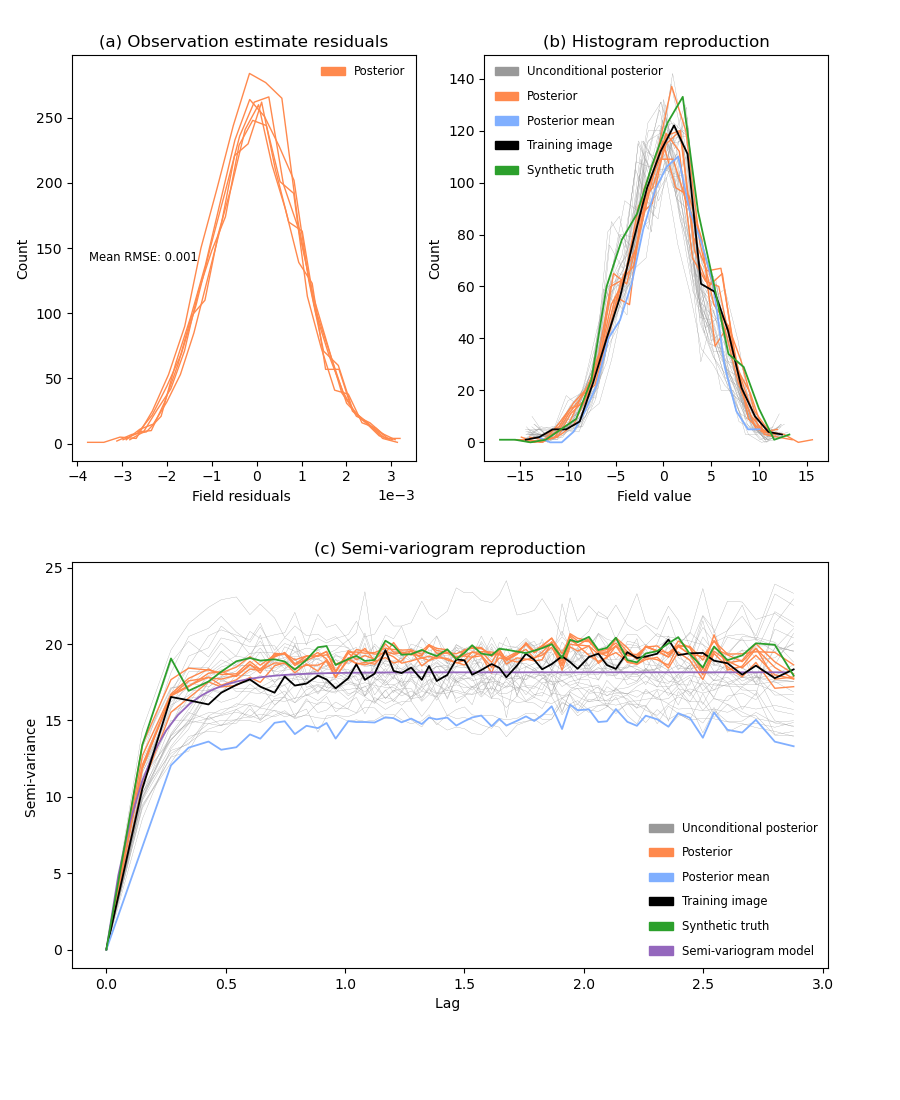

In [66]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

surface.grid_glq(nmax = shn, r_at = 1.0)
#surface.m_equiv_lsq
mt_util.plot_sdssim_reproduce(surface, surface.m_DSS_res, m_equiv_lsq = None,
                              lwidth = 1, lwidth_mult = 1.3, lwidth_div=5,
                              truth_obj = surface_t, uncon_obj = surface_uncon,
                              spec_r_at = 1.0, spec_use = False, spec_show_differences = False, spec_mag = False,
                              figsize=(9,11), hist_pos_mean = True, sv_pos_mean = True, lags_use = 1000,
                              unit_var = "", unit_lag = "", unit_field = "", unit_res = "",
                              hist_bins = 20, res_bins = 20, patch_legend = True,
                              res_power_format = True, power_limit = -3, res_print_f = 3,
                              savefig = True, save_string = "simple_ex_fisher", save_path = "images/", save_dpi = 300)

In [51]:
set_nmax = shn
r_at = 1.0

surface.grid_glq(nmax = 400, r_at = r_at)

# Posterior
zs_eqa = []
for i in np.arange(0,surface.g_spec.shape[1]):
    z_grid = mt_util.sh_makegrid_glq(surface.g_spec[:,i], surface.grid_nmax, surface.grid_zero, set_nmax)
    
    zs_eqa.append(z_grid.reshape(-1,))
zs_eqa = np.array(zs_eqa).T

# Unconditional posterior
zs_uncon = []
for i in np.arange(0,surface.g_spec.shape[1]):
    z_grid = mt_util.sh_makegrid_glq(surface_uncon.g_spec[:,i], surface.grid_nmax, surface.grid_zero, set_nmax)
    
    zs_uncon.append(z_grid.reshape(-1,))
zs_uncon = np.array(zs_uncon).T

# Posterior mean
zs_mean_eqa = mt_util.sh_makegrid_glq(surface.g_spec_mean, surface.grid_nmax, surface.grid_zero, set_nmax)

# Truth
prior_eqa = mt_util.sh_makegrid_glq(surface_t.g_prior[:mt_util.shc_vec_len(set_nmax)], surface.grid_nmax, surface.grid_zero, set_nmax)

# LSQ
lsq_eqa = mt_util.sh_makegrid_glq(surface.g_equiv_lsq, surface.grid_nmax, surface.grid_zero, set_nmax)

<IPython.core.display.Javascript object>


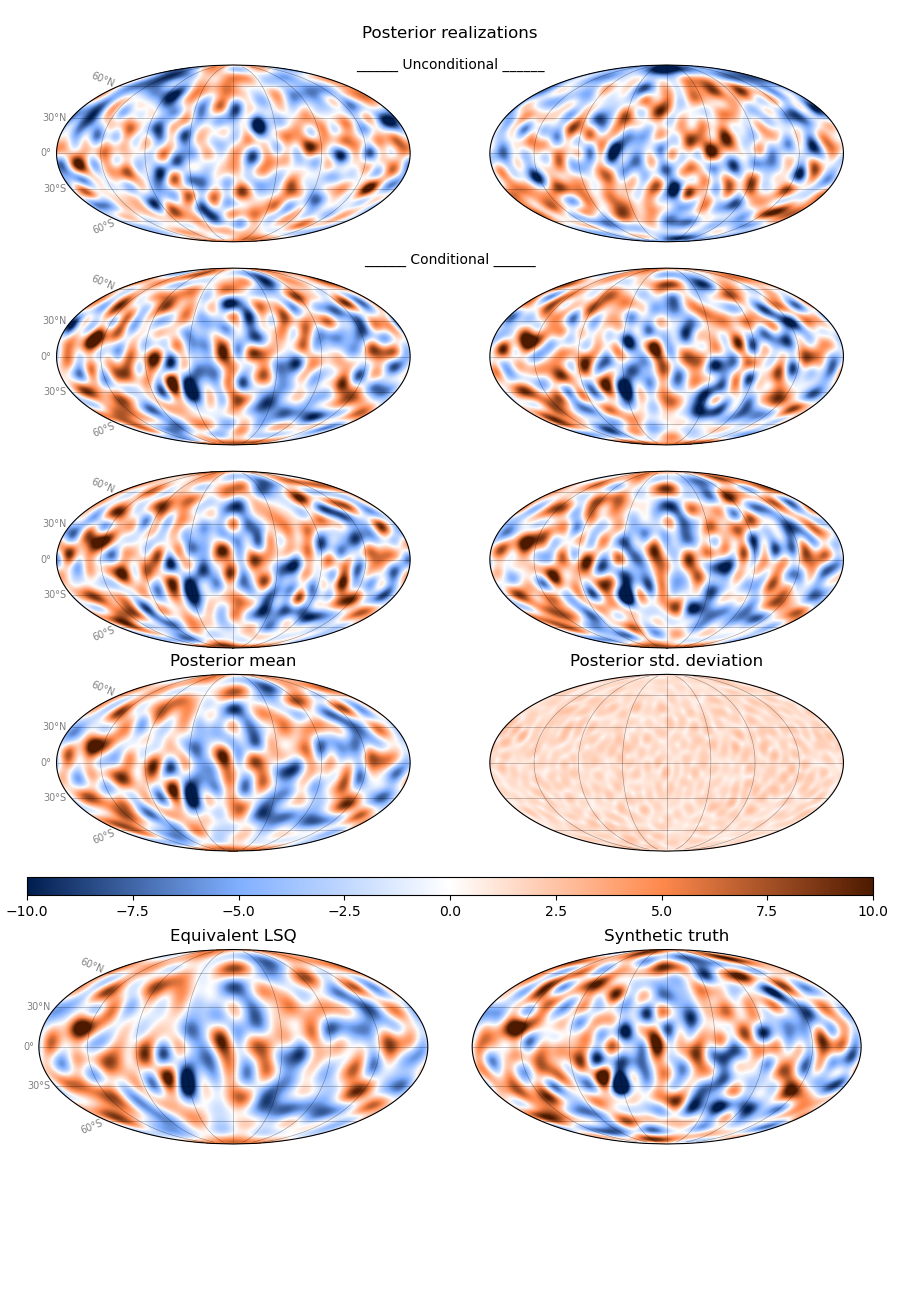

In [64]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(surface.grid_phi, 90-surface.grid_theta, zs_eqa, field_uncon = zs_uncon,
                        field_compare = prior_eqa, field_lsq = lsq_eqa, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,13), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1,
                        coast_width = 0.0, coast_color = "grey", unit_transform_n_to_m = False,
                        cbar_h = 0.1, cbar_text = "", cbar_text_color = "black", cbar_limit = [-10,10],
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "simple_ex_fisher", save_path = "images/",
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


In [28]:
# SAVE RESULT
#surface_uncon.pickle_save_self(nb_name, name_append = "_unconditional")
#surface.pickle_save_self(nb_name, name_append = "_conditional")